In [2]:
import torch
import numpy as np
import pickle
from torchvision import datasets
import os
import ssl
import random
from Lipschitz.tinyimagenet_dataset import Tiny_ImageNet

np.random.seed(0)
random.seed(0)
softmax_temperature = 1e-3
softmax_temperature_metric = 1.
max_lip_c = 1e6
milp_time_limit = 600
dataset_name = "tiny-imagenet-200" # tiny-imagenet-200, stl10, cifar10, cifar100
val_split_ver = "val_64"
ssl._create_default_https_context = ssl._create_unverified_context


if dataset_name == "stl10":
    train_set = datasets.STL10(root=f'../datasets/{dataset_name}/', split='train', download=True)
    test_set = datasets.STL10(root=f'../datasets/{dataset_name}/', split='test', download=True)
elif dataset_name == "tiny-imagenet-200":
    train_set = Tiny_ImageNet(root=f'../datasets/{dataset_name}/', split='train')
    test_set = Tiny_ImageNet(root=f'../datasets/{dataset_name}/', split='test')
elif dataset_name == "cifar10":
    train_set = datasets.CIFAR10(root=f'../datasets/{dataset_name}/', train=True, download=True)
    test_set = datasets.CIFAR10(root=f'../datasets/{dataset_name}/', train=False, download=True)
elif dataset_name == "cifar100":
    train_set = datasets.CIFAR100(root=f'../datasets/{dataset_name}/', train=True, download=True)
    test_set = datasets.CIFAR100(root=f'../datasets/{dataset_name}/', train=False, download=True)
else:
    raise NotImplementedError("dataset not supported!")

if val_split_ver == "val_64":
    val_number = int(len(train_set.data) * 0.4)
elif val_split_ver == "val_46":
    val_number = int(len(train_set.data) * 0.6)
elif val_split_ver == "val_1000":
    val_number = 1000
else:
    raise NotImplementedError("val_split_ver not supported!")
    
    
if os.path.exists(f"../datasets/{dataset_name}/training_validation_indices_{val_number}.pkl"):
    print(f"Loading training_validation_indices_{val_number}.pkl...")
    train_idxs, val_idxs = pickle.load(open(f"../datasets/{dataset_name}/training_validation_indices_{val_number}.pkl", "rb"))
else:
    raise ValueError(f"training_validation_indices_{val_number}.pkl not found!")
val_input_images = train_set.data[val_idxs].reshape(len(val_idxs), -1)
assert len(val_input_images) == val_number, "val_input_images not the same as val_number!"
feature_type2feature = {"val_input_images": val_input_images}

classifier_type_list = ["resnet18", "resnet34", "resnet50", "resnet101", "swin_v2_t", "swin_v2_s", "swin_v2_b"]
classifier_type2probs = {}
classifier_type2succ_probs = {}
val_targets_list = []
for classifier_type in classifier_type_list:
    val_target = np.hstack([_.numpy() for _ in torch.load(f'../results/{val_split_ver}/{dataset_name}/{classifier_type}_nn_feature_np/val_target_list.pt', map_location='cpu')])
    if len(val_targets_list) == 0:
        val_targets_list = val_target
    else:
        assert np.all(val_targets_list == val_target), "val_target_list not the same across classifiers!"

    classifier_type2probs[classifier_type] = np.vstack(
        [torch.nn.functional.softmax(_ / softmax_temperature, dim=1).detach().numpy() for _ in
         torch.load(f'../results/{val_split_ver}/{dataset_name}/{classifier_type}_nn_feature_np/val_logit_list.pt', map_location='cpu')])

    x_succprob_list = []
    for target, probs in zip(val_targets_list, classifier_type2probs[classifier_type]):
        x_succprob_list.append(probs[target])
    classifier_type2succ_probs[classifier_type] = np.array(x_succprob_list)

metric_base_model_list = ["resnet18", "resnet34", "resnet50", "resnet101", "swin_v2_t", "swin_v2_s", "swin_v2_b"]
metric_base_model2probs = {}
for _ in metric_base_model_list:
    metric_base_model2probs[_] = np.vstack(
        [torch.nn.functional.softmax(_ / softmax_temperature_metric, dim=1).detach().numpy() for _ in
         torch.load(f'../results/{val_split_ver}/{dataset_name}/{_}_nn_feature_np/val_logit_list.pt',
                    map_location='cpu')])


Loading training_validation_indices_40000.pkl...


In [3]:
# divide validation set into k folds and fit k 1nn searchers
from sklearn.neighbors import NearestNeighbors

metric_p = np.inf           # np.inf or 1 or 2
val_fold_num = 40           # number of folds, K=40 by default
val_fold_size = len(val_targets_list) // val_fold_num
feature_type = "val_input_images"
metric_base_model = 'resnet18' # None or 'resnet18' or 'swin_v2_t'
metric_base_model_idx = 0       # 0 for resnet18, 1 for resnet34, 2 for resnet50, 3 for resnet101, 4 for resnet152, 5 for swin_v2_t, 6 for swin_v2_s, 7 for swin_v2_b

print(f"metric_base_model: {metric_base_model}; metric_p: L-{metric_p}; feature: {feature_type}")

if metric_base_model is not None:
    val_feature_list = metric_base_model2probs[metric_base_model].reshape(len(val_targets_list), -1)
else:
    val_feature_list = feature_type2feature[feature_type].reshape(len(val_targets_list), -1)

metric_base_model: resnet18; metric_p: L-inf; feature: val_input_images


In [4]:
# test
test_input_images = test_set.data.reshape(len(test_set.data), -1)
test_targets_list = []
classifier_type2test_probs = {}
classifier_type2test_succ_probs = {}
classifier_type2test_argmax = {}

# get ground truth for each classifier (i.e., success prob. for each test sample)
for classifier_type in classifier_type_list:
    test_target = np.hstack([_.numpy() for _ in torch.load(f'../results/{val_split_ver}/{dataset_name}/{classifier_type}_nn_feature_np/test_target_list.pt', map_location='cpu')])
    if len(test_targets_list) == 0:
        test_targets_list = test_target
    else:
        assert np.all(test_targets_list == test_target), "test_target_list not the same across classifiers!"

    classifier_type2test_probs[classifier_type] = np.vstack(
        [torch.nn.functional.softmax(_ / softmax_temperature, dim=1).detach().numpy() for _ in
         torch.load(f'../results/{val_split_ver}/{dataset_name}/{classifier_type}_nn_feature_np/test_logit_list.pt', map_location='cpu')])

    x_succprob_list = []
    x_argmax_list = []
    for target, probs in zip(test_targets_list, classifier_type2test_probs[classifier_type]):
        x_succprob_list.append(probs[target])
        x_argmax_list.append(max(probs) == probs[target])
    classifier_type2test_succ_probs[classifier_type] = np.array(x_succprob_list)
    classifier_type2test_argmax[classifier_type] = np.array(x_argmax_list) * 1

metric_base_model2test_probs = {}
for _ in metric_base_model_list:
    metric_base_model2test_probs[_] = np.vstack(
        [torch.nn.functional.softmax(_ / softmax_temperature_metric, dim=1).detach().numpy() for _ in
         torch.load(f'../results/{val_split_ver}/{dataset_name}/{_}_nn_feature_np/test_logit_list.pt',
                    map_location='cpu')])

if metric_base_model is not None:
    test_feature_list = metric_base_model2test_probs[metric_base_model].reshape(len(test_targets_list), -1)
else:
    test_feature_list = test_input_images.reshape(len(test_targets_list), -1)

In [5]:
# 1nn search for each test sample on all validation folds
import matplotlib.pyplot as plt

nn_searcher_list = []
for i in range(val_fold_num):
    nn_searcher_list.append(NearestNeighbors(n_neighbors=1, p=metric_p).fit(val_feature_list[val_fold_size * i : val_fold_size * (i + 1)]))

nn_idx_list = []
for i in range(val_fold_num):
    nn_idx_list.append(nn_searcher_list[i].kneighbors(test_feature_list, n_neighbors=1, return_distance=False).reshape(-1) + i * val_fold_size)

classifier_type2succprob_est_list = {}
classifier_type2est_std_list = {}
# estimate local lip_c for each classifier
for classifier_type in classifier_type_list:
    x_succprob_list = classifier_type2succ_probs[classifier_type]
    x_succprob_test_list = classifier_type2test_succ_probs[classifier_type]

    succprob_est_list = np.mean([x_succprob_list[_] for _ in nn_idx_list], axis=0)
    classifier_type2succprob_est_list[classifier_type] = succprob_est_list
    classifier_type2est_std_list[classifier_type] = np.std((succprob_est_list - x_succprob_test_list)) 

    print(f"classifier: {classifier_type}")
    print(f"average succprob: {np.mean(x_succprob_test_list):.4f}, est: {np.mean(succprob_est_list):.4f}")
    print(f"validity: {np.mean(succprob_est_list <= x_succprob_test_list):.2f}")
    print(f"agg. tightness: {np.mean(succprob_est_list - x_succprob_test_list):.2f}")
    print(f"ind. tightness: {np.mean(np.abs(succprob_est_list - x_succprob_test_list)):.2f}")
    print(f"std: {classifier_type2est_std_list[classifier_type]:.4f}")
    print("")


/Users/dalton386/Desktop/Model Portfolio/Codes/Lipschitz/venv/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


classifier: resnet18
average succprob: 0.6556, est: 0.6286
validity: 0.66
agg. tightness: -0.03
ind. tightness: 0.29
std: 0.3827

classifier: resnet34
average succprob: 0.7049, est: 0.6795
validity: 0.70
agg. tightness: -0.03
ind. tightness: 0.32
std: 0.4031

classifier: resnet50
average succprob: 0.7192, est: 0.6913
validity: 0.72
agg. tightness: -0.03
ind. tightness: 0.32
std: 0.3956

classifier: resnet101
average succprob: 0.7565, est: 0.7324
validity: 0.76
agg. tightness: -0.02
ind. tightness: 0.30
std: 0.3873

classifier: swin_v2_t
average succprob: 0.7848, est: 0.7626
validity: 0.78
agg. tightness: -0.02
ind. tightness: 0.29
std: 0.3800

classifier: swin_v2_s
average succprob: 0.8242, est: 0.8045
validity: 0.82
agg. tightness: -0.02
ind. tightness: 0.26
std: 0.3570

classifier: swin_v2_b
average succprob: 0.8249, est: 0.8073
validity: 0.82
agg. tightness: -0.02
ind. tightness: 0.26
std: 0.3562



In [6]:
# ILP formulation
from scipy.optimize import LinearConstraint, Bounds, milp

test_size = len(test_targets_list)
classifier_num = len(classifier_type_list)
# normalized cost; need to be aligned with classifier_type_list
classifier_cost_list = np.asarray([88.9, 135.9, 174.5, 317.4, 326.4, 600.7, 610.6]) / 3600 * 3.06 * 1000

test_slice_ind_bases = np.arange(classifier_num) * test_size
test_slice_ones = np.ones(classifier_num)

ilp_bounds = Bounds(lb=0, ub=1)
# the uniqueness constraint: one classifier can only be used once on one test sample
ilp_A_uniq = np.zeros((test_size, test_size * classifier_num))
[np.put(A_row, test_slice_ind_bases + i, test_slice_ones) for i, A_row in enumerate(ilp_A_uniq)]
ilp_b_l = np.ones(test_size)
ilp_b_u = np.ones(test_size)
# the cost constraint: the sum of the cost of the classifiers used should be less than user specified budget
ilp_A = np.vstack([ilp_A_uniq, np.hstack([np.ones(test_size) * cost for cost in classifier_cost_list])])
ilp_b_l = np.hstack([ilp_b_l, 0])
ilp_b_u = np.hstack([ilp_b_u, -1])  # replace -1 w/ user specified budget
ilp_constraints = LinearConstraint(ilp_A, ilp_b_l, ilp_b_u)
# the integrality constraint: the indicator of classifiers used should be either 0 or 1
ilp_integrality = np.ones(test_size * classifier_num, dtype=int) 

test_succ_probs_list = np.vstack([classifier_type2test_succ_probs[classifier_type] for classifier_type in classifier_type_list])
test_argmax_list = np.vstack([classifier_type2test_argmax[classifier_type] for classifier_type in classifier_type_list])
    

In [7]:
total_cost_budget_list = np.asarray(sorted(np.hstack([np.arange(classifier_cost_list[_], classifier_cost_list[_+1], 30) for _ in range(len(classifier_cost_list) - 1)] + [classifier_cost_list[-1] * _ for _ in [0.6, 0.8, 0.9, 1]]) * test_size))

In [11]:
# Our method

lambda_classifier_est_std = 5

classifiers_succprob_est_list = np.hstack([classifier_type2succprob_est_list[classifier_type] - classifier_type2est_std_list[classifier_type] * lambda_classifier_est_std for classifier_type in classifier_type_list])

ilp_A_no_base = np.vstack([ilp_A_uniq, np.hstack([np.zeros(test_size) if idx == metric_base_model_idx else np.ones(test_size) * cost for idx, cost in enumerate(classifier_cost_list)])])
base_service_cost = classifier_cost_list[metric_base_model_idx] * test_size

test_accuracy_list_ours = []
test_accuracy_argmax_list_ours = []
model_usage_along_budget_list = []
for _total_cost_budget in total_cost_budget_list:
    if metric_base_model is not None:
        ilp_b_u[-1] = _total_cost_budget - base_service_cost
        ilp_constraints = LinearConstraint(ilp_A_no_base, ilp_b_l, ilp_b_u)
    else:
        ilp_b_u[-1] = _total_cost_budget
        ilp_constraints = LinearConstraint(ilp_A, ilp_b_l, ilp_b_u)
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.milp.html
    # convert to minimization problem
    res = milp(c=classifiers_succprob_est_list * -1., constraints=ilp_constraints, integrality=ilp_integrality, bounds=ilp_bounds, options={"time_limit": milp_time_limit})
    try:
        res.x = res.x.reshape(classifier_num, test_size)
        res.x = np.round(res.x).astype(bool)
        model_usage_along_budget_list.append(np.sum(res.x, axis=1))
        test_accuracy_list_ours.append(np.mean(test_succ_probs_list[res.x]))
        test_accuracy_argmax_list_ours.append(np.mean(test_argmax_list[res.x]))
    except AttributeError:
        test_accuracy_list_ours.append(np.nan)
        test_accuracy_argmax_list_ours.append(np.nan)

model_usage_along_budget_list = np.vstack(model_usage_along_budget_list).transpose(1, 0)

In [12]:
# baselines
# 1. single best/largest model within the budget

test_accuracy_list_single_best = []
test_accuracy_argmax_list_single_best = []
for _total_cost_budget in total_cost_budget_list:
    avg_budget_per_call = _total_cost_budget / test_size
    largest_model_idx = np.argmax((classifier_cost_list <= avg_budget_per_call) * classifier_cost_list)
    test_accuracy_list_single_best.append(np.mean(classifier_type2test_succ_probs[classifier_type_list[largest_model_idx]]))
    test_accuracy_argmax_list_single_best.append(np.mean(classifier_type2test_argmax[classifier_type_list[largest_model_idx]]))


In [13]:
# 2. Random selection - Uniformly sample the constraint matrix and solve the ILP problem; average over 10 runs

rand_total_cost_list = []
rand_expected_acc_list = []
rand_expected_acc_lb_list = []
test_accuracy_list_random = []
test_accuracy_argmax_list_random = []
for _ in range(3):
    rand_classifiers_succprob_est_list = np.random.rand(test_size * classifier_num)
    _test_accuracy_list_random = []
    _test_accuracy_argmax_list_random = []
    
    for _total_cost_budget in total_cost_budget_list:
        ilp_b_u[-1] = _total_cost_budget
        ilp_constraints = LinearConstraint(ilp_A, ilp_b_l, ilp_b_u)
    
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.milp.html
        res = milp(c=rand_classifiers_succprob_est_list * -1., constraints=ilp_constraints, integrality=ilp_integrality, bounds=ilp_bounds, options={"time_limit": milp_time_limit})
        try:
            res.x = res.x.reshape(classifier_num, test_size)
            res.x = np.round(res.x).astype(bool)
            _test_accuracy_list_random.append(np.mean(test_succ_probs_list[res.x]))
            _test_accuracy_argmax_list_random.append(np.mean(test_argmax_list[res.x]))
        except AttributeError:
            _test_accuracy_list_random.append(np.nan)
            _test_accuracy_argmax_list_random.append(np.nan)
    
    test_accuracy_list_random.append(_test_accuracy_list_random)
    test_accuracy_argmax_list_random.append(_test_accuracy_argmax_list_random)

test_accuracy_list_random = np.mean(test_accuracy_list_random, axis=0)
test_accuracy_argmax_list_random = np.mean(test_accuracy_argmax_list_random, axis=0)
 

In [14]:
# 3. FrugalMCT: Efficient API selection paper - train accuracy predictor (random forest); check codes for implementation

from sklearn.ensemble import RandomForestRegressor

frugal_mct_accuracy_predictor = RandomForestRegressor()
# train accuracy predictor
frugal_mct_base_model = 'resnet18'  # 'resnet18' or 'swin_v2_t'
assert frugal_mct_base_model == metric_base_model, "frugal_mct_base_model not equal to metric_base_model!"

frugal_mct_feature_list = metric_base_model2probs[frugal_mct_base_model].reshape(len(val_targets_list), -1)
frugal_mct_classifier_acc_list = np.hstack([classifier_type2succ_probs[classifier_type].reshape(-1, 1) for classifier_type in classifier_type_list])
frugal_mct_test_feature_list = metric_base_model2test_probs[frugal_mct_base_model].reshape(len(test_targets_list), -1)

frugal_mct_accuracy_predictor.fit(frugal_mct_feature_list, frugal_mct_classifier_acc_list)

frugal_mct_acc_est_list = np.hstack([_ for _ in frugal_mct_accuracy_predictor.predict(frugal_mct_test_feature_list).transpose(1, 0)])

test_accuracy_list_frugal_mct = []
test_accuracy_argmax_list_frugal_mct = []
ilp_A_frugal_mct = np.vstack([ilp_A_uniq, np.hstack([np.zeros(test_size) if idx == metric_base_model_idx else np.ones(test_size) * cost for idx, cost in enumerate(classifier_cost_list)])])
base_service_cost = classifier_cost_list[metric_base_model_idx] * test_size
for _total_cost_budget in total_cost_budget_list:
    ilp_b_u[-1] = _total_cost_budget - base_service_cost
    ilp_constraints = LinearConstraint(ilp_A_frugal_mct, ilp_b_l, ilp_b_u)

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.milp.html
    res = milp(c=frugal_mct_acc_est_list * -1., constraints=ilp_constraints, integrality=ilp_integrality, bounds=ilp_bounds, options={"time_limit": milp_time_limit})
    try:
        res.x = res.x.reshape(classifier_num, test_size)
        res.x = np.round(res.x).astype(bool)
        
        test_accuracy_list_frugal_mct.append(np.mean(test_succ_probs_list[res.x]))
        test_accuracy_argmax_list_frugal_mct.append(np.mean(test_argmax_list[res.x]))
    except AttributeError:
        test_accuracy_list_frugal_mct.append(np.nan)
        test_accuracy_argmax_list_frugal_mct.append(np.nan)


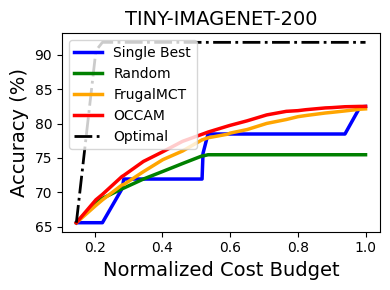

In [2]:
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(figsize=(4, 3))
single_image_ratio = 1e4
plt.plot(total_cost_budget_list / single_image_ratio / max(classifier_cost_list), np.array(test_accuracy_argmax_list_single_best) * 100, color='blue', linestyle='-', linewidth=2.5, label="Single Best")
plt.plot(total_cost_budget_list / single_image_ratio / max(classifier_cost_list), np.array(test_accuracy_argmax_list_random) * 100, color='green', linestyle='-', linewidth=2.5, label="Random")
plt.plot(total_cost_budget_list / single_image_ratio / max(classifier_cost_list), np.array(test_accuracy_argmax_list_frugal_mct) * 100, color='orange', linestyle='-', linewidth=2.5, label="FrugalMCT")
plt.plot(total_cost_budget_list / single_image_ratio / max(classifier_cost_list), np.array(test_accuracy_argmax_list_ours) * 100, color='red', linestyle='-', linewidth=2.5, label="OCCAM")
plt.xlabel("Normalized Cost Budget", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(np.arange(0.2, 1.1, 0.2))

plt.title(f"{dataset_name.upper()}", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (23,) (19,) 

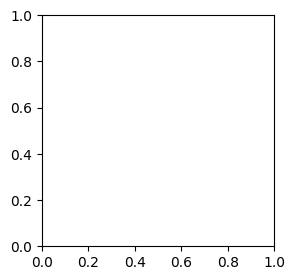

In [18]:
f = plt.figure(figsize=(3, 3))
single_image_ratio = 1e4

plt.stackplot(total_cost_budget_list / single_image_ratio / max(classifier_cost_list), model_usage_along_budget_list / test_size * 100, labels=classifier_type_list) 

plt.xticks(np.arange(0.2, 1.1, 0.2))

plt.xlabel("Normalized Cost Budget", fontsize=14)
plt.ylabel("Model Usage (%)", fontsize=14)
plt.title(f"{dataset_name.upper()}", fontsize=14)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()



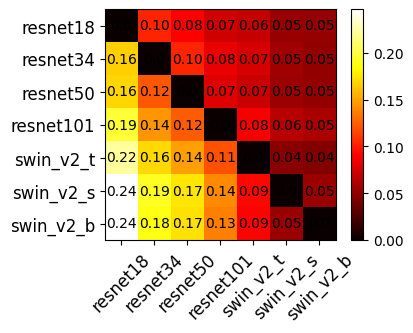

In [8]:
# One entry indicates the percent of cases that the classifier on its row is right but the classifier on its column gives the wrong answer
import matplotlib.pyplot as plt
failure_threshold = 1e-3

classifier_type_list_doubleline = ["resnet18", "resnet34", "resnet50", "resnet101", "swin-t", "swin-s", "swin-b"]
perf_mistake_matrix = np.zeros((len(classifier_type_list), len(classifier_type_list)))
for i, classifier_type in enumerate(classifier_type_list):
    for j, classifier_type2 in enumerate(classifier_type_list):
        perf_mistake_matrix[i, j] = np.count_nonzero(classifier_type2test_argmax[classifier_type2][classifier_type2test_argmax[classifier_type] > 1 - failure_threshold] < failure_threshold) / len(classifier_type2test_argmax[classifier_type2][classifier_type2test_argmax[classifier_type] > 1 - failure_threshold])

f = plt.figure(figsize=(4, 3))
plt.imshow(perf_mistake_matrix, cmap='hot', interpolation='nearest')
for (j,i),label in np.ndenumerate(perf_mistake_matrix):
    plt.text(i,j,str(label)[:4],ha='center',va='center', color='black')
plt.xticks(np.arange(len(classifier_type_list)), classifier_type_list, fontsize=12, rotation=45)
plt.yticks(np.arange(len(classifier_type_list)), classifier_type_list, fontsize=12)
plt.colorbar()
plt.show()